In [1]:
#imports

import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
import pandas as pd
from pyspark.ml.fpm import FPGrowth
from pyspark.storagelevel import StorageLevel
from pyspark import StorageLevel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.sql.window import Window
from pyspark.sql.functions import create_map, lit
from textwrap import fill
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.dates as mdates
from pyspark.ml.feature import StringIndexer

# Env & Paths
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

DRIVER_IP   = "172.19.0.9"                 # IP of the Jupyter container in spark-net (change if needed)
HDFS_BASE   = "hdfs://namenode:9000"
CSV_PATH    = f"{HDFS_BASE}/datasets/online_retail.csv"
PARQ_PATH   = f"{HDFS_BASE}/datasets/retail_clean_parquet"

LOCAL_OUT   = "/work/output"               # Output dir inside container (bind-mounted to host)
os.makedirs(LOCAL_OUT, exist_ok=True)      # Create if not exists


In [2]:
# Clean previous Spark session
try:
    spark.stop()
except:
    pass



DRIVER_IP = "172.19.0.9"   # Driver IP inside spark-net


#Build SparkSession
spark = (
    SparkSession.builder
      .appName("Retail_Project")
      .master("spark://spark-master:7077")
      .config("spark.driver.bindAddress", "0.0.0.0")
      .config("spark.driver.host", DRIVER_IP)
      # enforce same Python on driver & executors to avoid version mismatch
      .config("spark.pyspark.python", "python3")
      .config("spark.pyspark.driver.python", "python3")
      # modest resources for stability
      .config("spark.executor.instances", "2")
      .config("spark.executor.cores", "1")
      .config("spark.executor.memory", "1g")
      .config("spark.driver.memory", "1g")
      .getOrCreate()
)

# Verify Python settings are consistent
print("executor python =", spark.sparkContext.getConf().get("spark.pyspark.python"))
print("driver   python =", spark.sparkContext.getConf().get("spark.pyspark.driver.python"))

OUTDIR = "/work/output"
print("Spark ready:", spark.version)


25/10/13 15:19:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


executor python = python3
driver   python = python3
Spark ready: 3.0.0


In [3]:
"""
Step 1 — Load raw CSV
use first row as header
no schema inference; cast types explicitly later
"""


raw = (
    spark.read
         .option("header", True)  # use header row
         .csv(CSV_PATH)    # path on HDFS
)

print("raw rows =", raw.count())
raw.printSchema()
raw.show(5, truncate=False)  # path on HDFS

'''

Step 2 — Minimal cleaning & type casting
Goals:
1.filter credit notes (invoices starting with 'C')
2.cast Quantity/UnitPrice/CustomerID to numeric types
3.keep rows with positive Quantity & UnitPrice
4.parse InvoiceDate with multiple patterns; coalesce as fallback

'''
clean = (
    raw
    .filter(~F.col("InvoiceNo").startswith("C"))
    .withColumn("Quantity",  F.col("Quantity").cast("int"))    # cast quantity
    .withColumn("UnitPrice", F.col("UnitPrice").cast("double")) # cast unit price
    .withColumn("CustomerID", F.col("CustomerID").cast("int")) # cast customer id
    .withColumn(
        "InvoiceTs", # timestamp column
        F.coalesce(
            F.to_timestamp("InvoiceDate", "yyyy/M/d H:mm"),
            F.to_timestamp("InvoiceDate", "MM/dd/yyyy HH:mm"),
            F.to_timestamp("InvoiceDate")  
        )
    )
    .filter( (F.col("Quantity") > 0) & (F.col("UnitPrice") > 0) )  # keep positive values
)

print("clean rows =", clean.count())   # cleaned row count
clean.printSchema()               # schema after casting
clean.show(5, truncate=False)     # preview


raw rows = 541909
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850.0   |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |2010-12-01 08:26:00|3.39     |17850.0   |United Kingdom|
|536365   |84406B   |CREAM CUPI

clean rows = 530104
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceTs: timestamp (nullable = true)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |InvoiceTs          |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |71053    |WHITE

In [4]:
# Read raw CSV (infer schema)

aw = (spark.read
       .option("header", True)
       .option("inferSchema", True)
       .csv("hdfs://namenode:9000/datasets/online_retail.csv"))

# Derive basic fields
df = (raw
      .withColumn("InvoiceTS", F.to_timestamp("InvoiceDate", "M/d/yyyy H:mm"))
      .withColumn("YearMonth", F.date_format("InvoiceTS","yyyyMM"))
      .withColumn("IsCancelled", F.col("InvoiceNo").startswith("C"))
      .withColumn("Amount", (F.col("Quantity")*F.col("UnitPrice")).cast("double")) # line amount = Quantity * UnitPrice
     )
# Clean: drop cancellations and invalid rows
sales = (df
    .filter(~F.col("IsCancelled"))
    .filter(F.col("Quantity") > 0)
    .filter(F.col("UnitPrice") >= 0)
    .filter(F.col("InvoiceTS").isNotNull())
    .filter(F.col("CustomerID").isNotNull()))

# Write partitioned Parquet by YearMonth for faster downstream scans
(sales.repartition(8, "YearMonth")
 .write.mode("overwrite") # overwrite
 .partitionBy("YearMonth") # partition by YearMonth
 .parquet("hdfs://namenode:9000/datasets/retail_clean_parquet"))

print("Parquet ready") # success message

Parquet ready


In [5]:
# Overwrite Parquet (make sure `clean` is non-empty; usually validated via count() before write)
clean.write.mode("overwrite").parquet(PARQ_PATH)

# Read back immediately and cache in memory/disk for later reuse
sales = spark.read.parquet(PARQ_PATH).cache()

# Trigger an action to materialize cache and print row count
print("sales rows =", sales.count())
sales.printSchema()

# Show first 5 rows without truncation for a quick sanity check
sales.show(5, truncate=False)


sales rows = 530104
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceTs: timestamp (nullable = true)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |InvoiceTs          |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United Kingdom|2010-12-01 08:26:00|
|536365   |71053    |WHITE

In [6]:
# Count order lines per country and take Top-10 (descending by count)

top_country = (
    sales.groupBy("Country") # group by country
         .count() # count rows (= order lines)
         .orderBy(F.desc("count")) # sort by count descending
         .limit(10)
)

# Show results without truncation for clear inspection
top_country.show(truncate=False)


+--------------+------+
|Country       |count |
+--------------+------+
|United Kingdom|485123|
|Germany       |9040  |
|France        |8407  |
|EIRE          |7890  |
|Spain         |2484  |
|Netherlands   |2359  |
|Belgium       |2031  |
|Switzerland   |1966  |
|Portugal      |1501  |
|Australia     |1182  |
+--------------+------+



In [7]:
# Add a new column 'Revenue' on detail rows(Revenue = Quantity * UnitPrice)

sales_with_rev = sales.withColumn("Revenue", F.col("Quantity") * F.col("UnitPrice"))

# Aggregate total revenue per country (2-decimal rounding), sort desc, take top 10
country_rev = (
    sales_with_rev.groupBy("Country")  # group by country
                  .agg(F.round(F.sum("Revenue"), 2).alias("TotalRevenue"))   # sum revenue & round(2)
                  .orderBy(F.desc("TotalRevenue"))
                  .limit(10)
)

# Show results without truncation for clarity
country_rev.show(truncate=False)


+--------------+------------+
|Country       |TotalRevenue|
+--------------+------------+
|United Kingdom|9025222.08  |
|Netherlands   |285446.34   |
|EIRE          |283453.96   |
|Germany       |228867.14   |
|France        |209715.11   |
|Australia     |138521.31   |
|Spain         |61577.11    |
|Switzerland   |57089.9     |
|Belgium       |41196.34    |
|Sweden        |38378.33    |
+--------------+------------+



In [8]:
# Aggregate total revenue by (StockCode, Description); round to 2 decimals; sort desc and take top 10

product_rev = (
    sales_with_rev.groupBy("StockCode", "Description") # group by item
                  .agg(F.round(F.sum("Revenue"), 2).alias("TotalRevenue"))
                  .orderBy(F.desc("TotalRevenue"))
                  .limit(10)
)

# Show results without truncation to see full descriptions
product_rev.show(truncate=False)


+---------+----------------------------------+------------+
|StockCode|Description                       |TotalRevenue|
+---------+----------------------------------+------------+
|DOT      |DOTCOM POSTAGE                    |206248.77   |
|22423    |REGENCY CAKESTAND 3 TIER          |174484.74   |
|23843    |PAPER CRAFT , LITTLE BIRDIE       |168469.6    |
|85123A   |WHITE HANGING HEART T-LIGHT HOLDER|104340.29   |
|47566    |PARTY BUNTING                     |99504.33    |
|85099B   |JUMBO BAG RED RETROSPOT           |94340.05    |
|23166    |MEDIUM CERAMIC TOP STORAGE JAR    |81700.92    |
|M        |Manual                            |78110.27    |
|POST     |POSTAGE                           |78101.88    |
|23084    |RABBIT NIGHT LIGHT                |66964.99    |
+---------+----------------------------------+------------+



In [9]:
# Aggregate by calendar month 
# Truncate timestamp to month start (00:00:00) as the group key
monthly = (
    sales_with_rev
        .withColumn("Month", F.date_trunc("month", F.col("InvoiceTs")))
        .groupBy("Month")  # Group by month and compute two metrics
        .agg(
            F.count(F.lit(1)).alias("RowCount"),  # RowCount: number of line items (not distinct invoices)

            F.round(F.sum("Revenue"), 2).alias("Revenue")  # Revenue: monthly total revenue, rounded to 2 decimals
        )
        .orderBy("Month") # Sort chronologically by month
)
# Show up to 24 rows with no truncation (for readability)
monthly.show(24, truncate=False)


+-------------------+--------+----------+
|Month              |RowCount|Revenue   |
+-------------------+--------+----------+
|2010-12-01 00:00:00|41480   |823746.14 |
|2011-01-01 00:00:00|34306   |691364.56 |
|2011-02-01 00:00:00|27105   |523631.89 |
|2011-03-01 00:00:00|35803   |717639.36 |
|2011-04-01 00:00:00|29096   |537808.62 |
|2011-05-01 00:00:00|36164   |770536.02 |
|2011-06-01 00:00:00|35977   |761739.9  |
|2011-07-01 00:00:00|38645   |719221.19 |
|2011-08-01 00:00:00|34483   |759138.38 |
|2011-09-01 00:00:00|49261   |1058590.17|
|2011-10-01 00:00:00|59304   |1154979.3 |
|2011-11-01 00:00:00|83369   |1509496.33|
|2011-12-01 00:00:00|25111   |638792.68 |
+-------------------+--------+----------+



In [10]:
# Convert timestamp/date columns to string for safe toPandas/CSV

def stringify_datetime_cols(df):  
    dt_cols = [name for name, dtype in df.dtypes if dtype in ("timestamp", "date")] # Detect timestamp/date columns in Spark DataFrame
    out = df
    for c in dt_cols:
        out = out.withColumn(c, F.date_format(F.col(c), "yyyy-MM-dd HH:mm:ss")) # Format each datetime column as string "yyyy-MM-dd HH:mm:ss"
    return out

# Only convert small results to pandas before writing CSV to avoid OOM
top_country_csv = stringify_datetime_cols(top_country).toPandas()
country_rev_csv = stringify_datetime_cols(country_rev).toPandas()
product_rev_csv = stringify_datetime_cols(product_rev).toPandas()
monthly_csv     = stringify_datetime_cols(monthly).toPandas()

# Save CSVs to mapped local folder /work/output
top_country_csv.to_csv(f"{LOCAL_OUT}/top10_country_counts.csv", index=False)
country_rev_csv.to_csv(f"{LOCAL_OUT}/top10_country_revenue.csv", index=False)
product_rev_csv.to_csv(f"{LOCAL_OUT}/top10_product_revenue.csv", index=False)
monthly_csv.to_csv(f"{LOCAL_OUT}/monthly_trend.csv", index=False)

# Also export a small random sample for quick inspection
sample_csv = stringify_datetime_cols(
    sales.sample(False, 0.001, seed=42).limit(1000)
).toPandas()
sample_csv.to_csv(f"{LOCAL_OUT}/retail_sample_1k.csv", index=False)

print("Wrote files under:", LOCAL_OUT) # print output folder


Wrote files under: /work/output


Saved: /work/output/plot_top10_countries_count.png


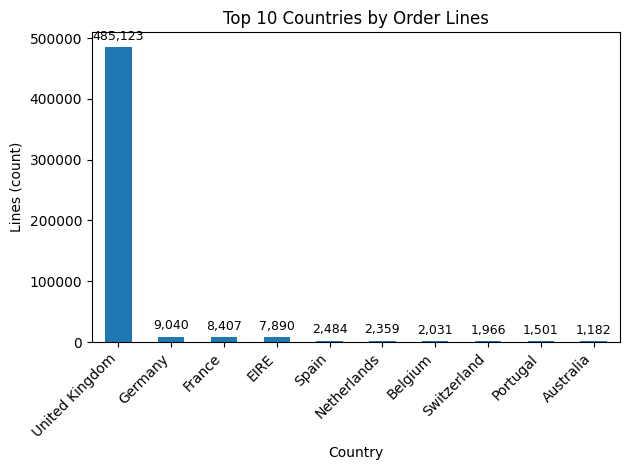

In [11]:
# Fallback & create output folder

OUTDIR = OUTDIR if 'OUTDIR' in globals() else "./output"
os.makedirs(OUTDIR, exist_ok=True)

pdf = top_country.toPandas().sort_values("count", ascending=False) # Convert small Spark DF to pandas and sort by count (desc)


# Plot bar chart: Country vs order lines (count)
ax = pdf.plot(kind="bar", x="Country", y="count", legend=False)
ax.set_title("Top 10 Countries by Order Lines")
ax.set_xlabel("Country")
ax.set_ylabel("Lines (count)")
plt.xticks(rotation=45, ha="right")

# Annotate each bar with value (thousand separator), slightly above the bar
for p, v in zip(ax.patches, pdf["count"].values):
    ax.annotate(f"{int(v):,}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9)


plt.tight_layout()# 紧凑排版防止标签被裁剪 / compact layout to avoid clipping

# Save figure to output folder
path = f"{OUTDIR}/plot_top10_countries_count.png"
plt.savefig(path, dpi=140)
print("Saved:", path)
plt.show()


Saved: /work/output/plot_top10_countries_revenue.png


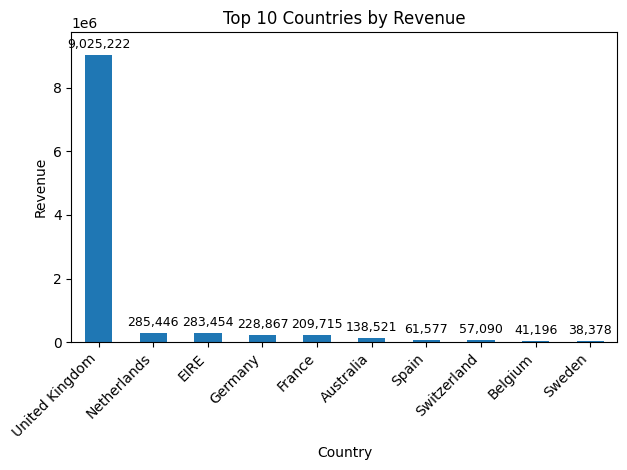

In [12]:
# Fallback & create output folder
OUTDIR = OUTDIR if 'OUTDIR' in globals() else "./output"
os.makedirs(OUTDIR, exist_ok=True)

pdf = country_rev.toPandas().sort_values("TotalRevenue", ascending=False) # Convert small Spark DF to pandas and sort by TotalRevenue (desc)


# Plot bar chart: Country vs Total Revenue

ax = pdf.plot(kind="bar", x="Country", y="TotalRevenue", legend=False)
ax.set_title("Top 10 Countries by Revenue")
ax.set_xlabel("Country")
ax.set_ylabel("Revenue")
plt.xticks(rotation=45, ha="right")

# Annotate values on top of bars (thousand separator)
for p, v in zip(ax.patches, pdf["TotalRevenue"].values):
    ax.annotate(f"{v:,.0f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9)

# Add headroom so annotations are not clipped
ax.set_ylim(0, pdf["TotalRevenue"].max() * 1.08)

plt.tight_layout()

# Save figure to output folder
path = f"{OUTDIR}/plot_top10_countries_revenue.png"
plt.savefig(path, dpi=140)
print("Saved:", path)
plt.show()


Saved: /work/output/plot_top10_products_revenue.png


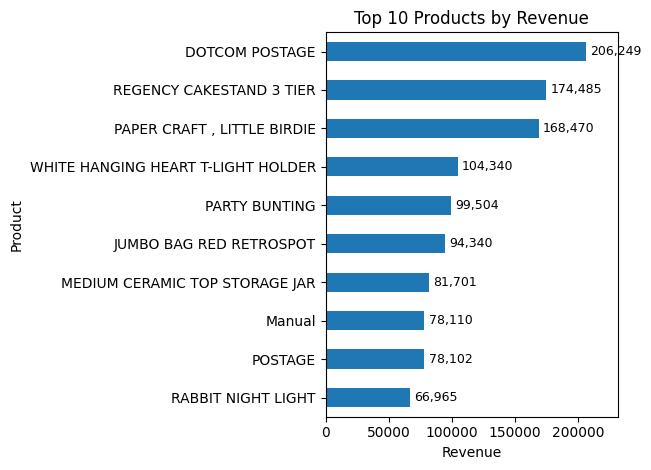

In [13]:
# Fallback & create output folder
OUTDIR = OUTDIR if 'OUTDIR' in globals() else "./output" 
os.makedirs(OUTDIR, exist_ok=True)


prod_pd = product_rev.toPandas().sort_values("TotalRevenue", ascending=True).copy() # Convert to pandas; keep ascending so horizontal bars grow upward

prod_pd["Label"] = prod_pd["Description"].fillna(prod_pd["StockCode"]).str.slice(0, 40) # Build readable label: prefer Description, fallback to StockCode; truncate to 40 chars

# Plot horizontal bar chart: Product vs Revenue
ax = prod_pd.plot(kind="barh", x="Label", y="TotalRevenue", legend=False)
ax.set_title("Top 10 Products by Revenue")
ax.set_xlabel("Revenue")
ax.set_ylabel("Product")


vals = prod_pd["TotalRevenue"].tolist()
for p, v in zip(ax.patches, vals):
    ax.annotate(f"{v:,.0f}",
                (p.get_width(), p.get_y() + p.get_height()/2),
                xytext=(3, 0), textcoords="offset points",
                ha="left", va="center", fontsize=9)

ax.set_xlim(0, max(vals) * 1.12)

# Save figure
plt.tight_layout()
png_path = f"{OUTDIR}/plot_top10_products_revenue.png"
plt.savefig(png_path, dpi=140)
print("Saved:", png_path)
plt.show()





Saved: /work/output/plot_monthly_trend.png


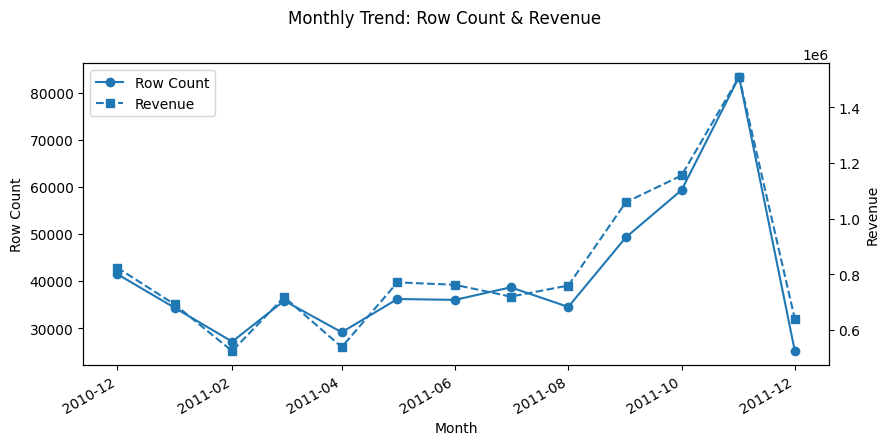

In [14]:
'''

Monthly trend: order lines & revenue
plot dual-axis lines and merge legends.

'''
# Convert Month to string first to avoid unit-less datetime64; keep ordering
monthly_safe = (
    monthly
    .select(
        F.date_format("Month", "yyyy-MM-dd HH:mm:ss").alias("Month_str"),
        "RowCount", "Revenue"
    )
    .orderBy("Month_str")
)

# Safe toPandas (strings + numerics only)
monthly_pd = monthly_safe.toPandas()

# Explicitly cast to datetime64[ns] to avoid FutureWarning/TypeError
# Fix pandas 2.x unit-less datetime64 issue when converting Spark->pandas
monthly_pd["Month"] = pd.to_datetime(
    monthly_pd["Month_str"],
    format="%Y-%m-%d %H:%M:%S",
    errors="coerce"
)
monthly_pd = monthly_pd.dropna(subset=["Month"]) # Drop rows with invalid datetimes (if any)

# Plot
fig, ax1 = plt.subplots(figsize=(9, 4.5))

# Left y-axis: order line count
lns1 = ax1.plot(
    monthly_pd["Month"], monthly_pd["RowCount"],
    marker="o", linewidth=1.5, label="Row Count"
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Row Count")

# Right y-axis: revenue
ax2 = ax1.twinx()
lns2 = ax2.plot(
    monthly_pd["Month"], monthly_pd["Revenue"],
    marker="s", linestyle="--", linewidth=1.5, label="Revenue"
)
ax2.set_ylabel("Revenue")

# Merge legends from both axes
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left", frameon=True)

# X-axis: major tick every 2 months, format yyyy-MM
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()

fig.suptitle("Monthly Trend: Row Count & Revenue")
plt.tight_layout()

# Save figure (fallback to /work/output if OUTDIR is undefined)
OUTDIR = globals().get("OUTDIR", "/work/output")
png_path = f"{OUTDIR}/plot_monthly_trend.png"
plt.savefig(png_path, dpi=140, bbox_inches="tight")
print("Saved:", png_path)
plt.show()


In [15]:
# Load the cleaned detail dataset
sales = spark.read.parquet("hdfs://namenode:9000/datasets/retail_clean_parquet")

# Keep only rows with positive quantity & unit price
sales = sales.filter((F.col("Quantity") > 0) & (F.col("UnitPrice") > 0))

# Cache for later reuse; MEMORY_AND_DISK avoids OOM by spilling to disk
sales = sales.persist(StorageLevel.MEMORY_AND_DISK)

# Materialize the cache via an action; also print key cardinalities
print("rows =", sales.count(),
      "| customers =", sales.select("CustomerID").distinct().count(),
      "| products =", sales.select("StockCode").distinct().count(),
      "| invoices  =", sales.select("InvoiceNo").distinct().count())

sales.printSchema()
sales.show(5, truncate=False)


rows = 530104 | customers = 4339 | products = 3922 | invoices  = 19960
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceTs: timestamp (nullable = true)

+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate        |UnitPrice|CustomerID|Country       |InvoiceTs          |
+---------+---------+-----------------------------------+--------+-------------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |2010-12-01 08:26:00|2.55     |17850     |United King

In [16]:
# Tunable: keep items that appear in >= N baskets to shrink pair space
MIN_ITEM_BASKETS = 10

# Build market baskets per invoice: unique item set; drop baskets with <2 items
baskets = (
    sales.groupBy("InvoiceNo")
         .agg(F.collect_set("StockCode").alias("items"))
         .filter(F.size("items") >= 2)
         .persist(StorageLevel.MEMORY_AND_DISK)
)
N_basket = baskets.count()
print("baskets:", N_basket)

# Count in how many baskets each item appears; pre-filter infrequent items
item_cnt = (
    baskets.selectExpr("explode(items) as item")
           .groupBy("item").count()
           .withColumnRenamed("count","cnt")
           .persist(StorageLevel.MEMORY_AND_DISK)
)
freq_items = item_cnt.filter(F.col("cnt") >= MIN_ITEM_BASKETS)

# Generate within-basket item pairs (i<j) and count pair co-occurrences
left  = baskets.selectExpr("InvoiceNo", "posexplode(items) as (pos1, i)")
right = baskets.selectExpr("InvoiceNo", "posexplode(items) as (pos2, j)")

pairs_raw = (
    left.join(right, "InvoiceNo")
        .where(F.col("pos2") > F.col("pos1"))
        .select("i","j")
)

# Keep pairs where both items passed the frequency filter; then count pairs
pairs = (
    pairs_raw
    .join(freq_items.withColumnRenamed("item","i").select("i"), on="i")
    .join(freq_items.withColumnRenamed("item","j").select("j"), on="j")
    .groupBy("i","j").count()
    .withColumnRenamed("count","pair_cnt")
    .persist(StorageLevel.MEMORY_AND_DISK)
)

# Join back single-item counts to compute: support, confidence (i->j/j->i), lift
pairs2 = (pairs
    .join(item_cnt.withColumnRenamed("item","i").withColumnRenamed("cnt","cnt_i"), on="i")
    .join(item_cnt.withColumnRenamed("item","j").withColumnRenamed("cnt","cnt_j"), on="j")
    .withColumn("support",      F.col("pair_cnt") / F.lit(N_basket)) # Support = pair_cnt / total #baskets
          
    .withColumn("conf_i_to_j",  F.col("pair_cnt") / F.col("cnt_i")) # Confidence(i->j) = pair_cnt / cnt_i
    .withColumn("conf_j_to_i",  F.col("pair_cnt") / F.col("cnt_j")) 
          
    .withColumn("lift",F.col("support") / ((F.col("cnt_i")/F.lit(N_basket))*(F.col("cnt_j")/F.lit(N_basket)))) # Lift = support / (P(i)*P(j)) where P(i)=cnt_i/N_basket
    .persist(StorageLevel.MEMORY_AND_DISK)
)

# Attach human-readable item descriptions for easier interpretation
prod_names = (sales
    .groupBy("StockCode")
    .agg(F.first("Description", ignorenulls=True).alias("Desc"))
)
pairs_named = (pairs2
    .join(prod_names.withColumnRenamed("StockCode","i"), on="i", how="left")
    .withColumnRenamed("Desc","i_desc")
    .join(prod_names.withColumnRenamed("StockCode","j"), on="j", how="left")
    .withColumnRenamed("Desc","j_desc")
)

# Export Top-N pairs by co-occurrence count and by highest lift
TOPN = 20
top_count = pairs_named.orderBy(F.desc("pair_cnt")).limit(TOPN).toPandas()
top_lift  = pairs_named.orderBy(F.desc("lift")).limit(TOPN).toPandas()

top_count.to_csv(f"{OUTDIR}/pairs_top{TOPN}_by_count.csv", index=False)
top_lift.to_csv (f"{OUTDIR}/pairs_top{TOPN}_by_lift.csv",  index=False)

# Also write full pair metrics back to HDFS for later SQL/Hue exploration
(pairs_named
 .coalesce(1).write.mode("overwrite").option("header", True)
 .csv("hdfs://namenode:9000/datasets/out/pairs_metrics_all"))

print("Saved:", f"{OUTDIR}/pairs_top{TOPN}_by_count.csv", f"{OUTDIR}/pairs_top{TOPN}_by_lift.csv")


baskets: 18319


Saved: /work/output/pairs_top20_by_count.csv /work/output/pairs_top20_by_lift.csv


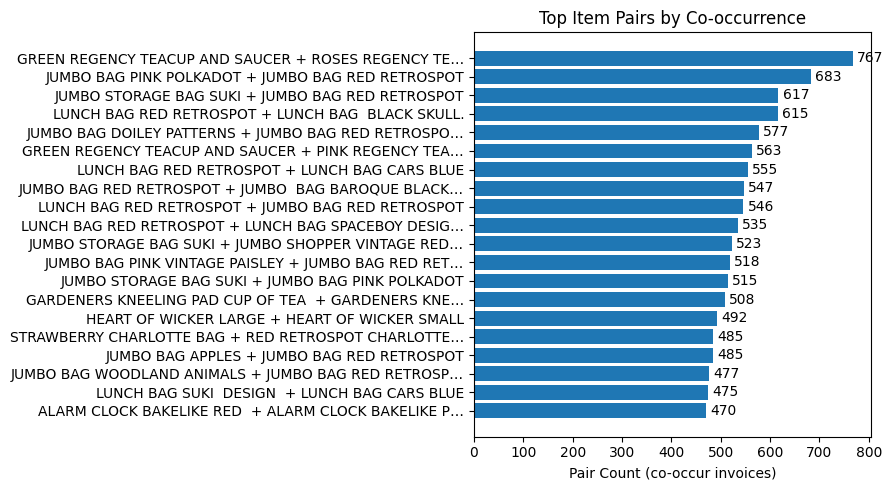

Saved plot: /work/output/plot_pairs_top_by_count.png


In [17]:
df_plot = top_count.copy()

# Build display label: prefer description; fall back to code if description is missing.
df_plot["pair"] = df_plot[["i_desc","j_desc","i","j"]].apply(
    lambda r: f'{(r["i_desc"] or r["i"])} + {(r["j_desc"] or r["j"])}', axis=1
)

# Truncate very long labels to improve readability.
MAX_LABEL = 50
df_plot["pair_short"] = df_plot["pair"].apply(
    lambda s: (s[:MAX_LABEL] + "…") if isinstance(s, str) and len(s) > MAX_LABEL else s
)


# Draw a horizontal bar chart; y = item pair, x = co-occurrence count.
fig, ax = plt.subplots(figsize=(9, 5))
ypos = range(len(df_plot))
bars = ax.barh(ypos, df_plot["pair_cnt"])

# Configure y ticks/labels; invert y so largest on top; set axis and chart titles.
ax.set_yticks(ypos)
ax.set_yticklabels(df_plot["pair_short"])
ax.invert_yaxis()  # 最大的在最上面
ax.set_xlabel("Pair Count (co-occur invoices)")
ax.set_title("Top Item Pairs by Co-occurrence")

# Annotate each bar end with its exact integer value.
for rect, val in zip(bars, df_plot["pair_cnt"].tolist()):
    x = rect.get_width()
    y = rect.get_y() + rect.get_height() / 2
    ax.annotate(str(int(val)), (x, y), xytext=(3, 0),
                textcoords="offset points", va="center")

# Save 
plt.tight_layout()
png_path = f"{OUTDIR}/plot_pairs_top_by_count.png"
plt.savefig(png_path, dpi=140)
plt.show()

print("Saved plot:", png_path)



RFM customers: 4338


25/10/13 15:23:11 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/10/13 15:23:11 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


+-------+------+------+--------+-----+
|segment|R_mean|F_mean|M_mean  |count|
+-------+------+------+--------+-----+
|0      |15.0  |22.3  |12709.1 |204  |
|1      |6.6   |82.5  |127338.3|13   |
|2      |248.2 |1.6   |478.2   |1061 |
|3      |43.4  |3.7   |1358.2  |3060 |
+-------+------+------+--------+-----+



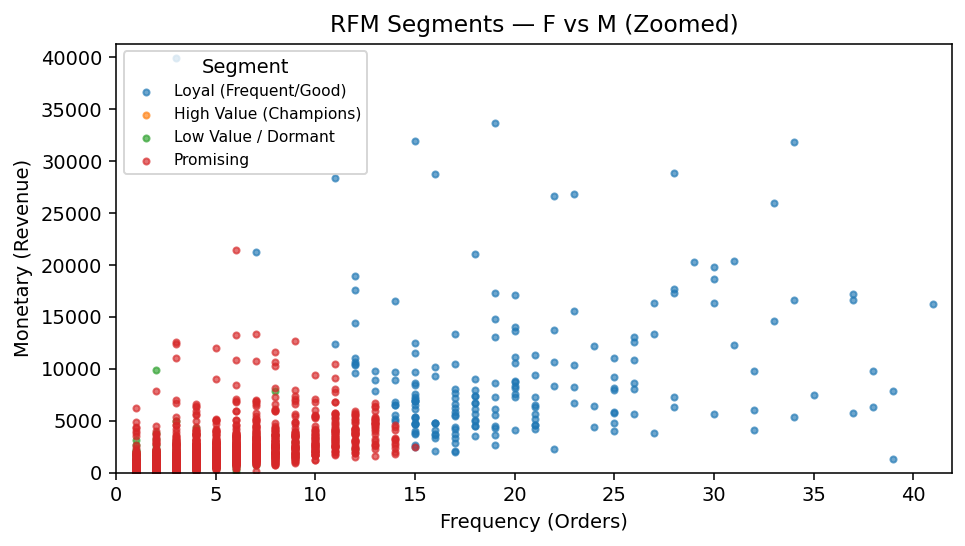

Saved plot: /work/output/plot_rfm_f_vs_m_small.png


In [18]:
# Output dir (reuse existing OUTDIR if already defined)
OUTDIR = globals().get("OUTDIR", "/work/output")
os.makedirs(OUTDIR, exist_ok=True)

# Prepare sales detail DataFrame
df0 = sales if "sales" in globals() else sales_with_rev
need_cols = ["InvoiceNo","CustomerID","InvoiceDate","Quantity","UnitPrice"]
missing = [c for c in need_cols if c not in df0.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}") # If missing 

# Pick timestamp column if exists; otherwise parse from InvoiceDa
ts_col = "InvoiceTs" if "InvoiceTs" in df0.columns else ("InvoiceTS" if "InvoiceTS" in df0.columns else None)
if ts_col is None:
    df0 = df0.withColumn("InvoiceTs",
                         F.coalesce(
                             F.to_timestamp("InvoiceDate", "yyyy/M/d H:mm"), # Recency (days since last purchase)
                             F.to_timestamp("InvoiceDate", "MM/dd/yyyy HH:mm"), # Frequency (orders)
                             F.to_timestamp("InvoiceDate") # Monetary (total spend)
                         ))
    ts_col = "InvoiceTs"

# Monetary amount: reuse Revenue if present; else Quantity*UnitPrice
if "Revenue" in df0.columns:
    df1 = df0.withColumn("Amount", F.col("Revenue").cast("double"))
else:
    df1 = df0.withColumn("Amount", (F.col("Quantity")*F.col("UnitPrice")).cast("double"))

# Basic filtering: non-null CustomerID / positive qty & price / non-null timestamp
df1 = (df1
       .filter(F.col("CustomerID").isNotNull())
       .filter((F.col("Quantity") > 0) & (F.col("UnitPrice") > 0))
       .filter(F.col(ts_col).isNotNull()))

# Reference day = max transaction date (more recent => smaller R)
max_ts = df1.select(F.max(F.col(ts_col)).alias("max_ts")).collect()[0]["max_ts"]
ref_day = max_ts

rfm = (
    df1.groupBy("CustomerID")
       .agg(
           F.datediff(F.lit(ref_day), F.max(F.col(ts_col))).alias("R"),              # Recency (天)
           F.countDistinct("InvoiceNo").alias("F"),                                  # Frequency (订单数)
           F.sum("Amount").cast("double").alias("M")                                  # Monetary (消费额)
       )
       .filter(F.col("F") > 0)
)

print("RFM customers:", rfm.count())

# Standardize features then run KMeans (k=4) on scaled features
vec = VectorAssembler(inputCols=["R","F","M"], outputCol="features")
rfm_vec = vec.transform(rfm)

scaler = StandardScaler(inputCol="features", outputCol="scaled", withStd=True, withMean=True)
rfm_std = scaler.fit(rfm_vec).transform(rfm_vec)

kmeans = KMeans(k=4, seed=42, featuresCol="scaled", predictionCol="segment")
rfm_pred = kmeans.fit(rfm_std).transform(rfm_std).cache()

# Segment summary table
summary = (rfm_pred.groupBy("segment")
           .agg(F.round(F.mean("R"),1).alias("R_mean"),
                F.round(F.mean("F"),1).alias("F_mean"),
                F.round(F.mean("M"),1).alias("M_mean"),
                F.count("*").alias("count"))
           .orderBy("segment"))

summary.show(truncate=False)  # show in notebook


summary.toPandas().to_csv(f"{OUTDIR}/rfm_segment_summary.csv", index=False)

'''
Small scatter (F vs M) + legend names (High Value / Loyal / Promising / Low Value)
Use raw means to name segments; map by descending mean M

'''
seg_stats_pd = (rfm_pred.groupBy("segment")
                .agg(F.mean("M").alias("M"), F.mean("F").alias("F"), F.mean("R").alias("R"))
                .toPandas())
seg_stats_pd = seg_stats_pd.sort_values("M", ascending=False)


name_map = {}
if len(seg_stats_pd) > 0: name_map[int(seg_stats_pd.iloc[0]["segment"])] = "High Value (Champions)"
if len(seg_stats_pd) > 1: name_map[int(seg_stats_pd.iloc[1]["segment"])] = "Loyal (Frequent/Good)"
if len(seg_stats_pd) > 2: name_map[int(seg_stats_pd.iloc[2]["segment"])] = "Promising"
# Others -> Low Value
for s in rfm_pred.select("segment").distinct().toPandas()["segment"].tolist():
    if s not in name_map:
        name_map[int(s)] = "Low Value / Dormant"

sample_rate = 1.0 if rfm_pred.count() <= 5000 else 0.6
plot_pd = rfm_pred.select("F","M","segment").sample(False, sample_rate, seed=42).toPandas()

# Limit axes by 99.5% quantile to reduce outlier stretching
f_max = float(plot_pd["F"].quantile(0.995)) if len(plot_pd) else 1.0
m_max = float(plot_pd["M"].quantile(0.995)) if len(plot_pd) else 1.0

# Plot and save
fig, ax = plt.subplots(figsize=(7, 4), dpi=140)
for seg_id, grp in plot_pd.groupby("segment"):
    ax.scatter(grp["F"], grp["M"], s=10, alpha=0.65, label=name_map.get(int(seg_id), f"Segment {seg_id}"))

ax.set_xlim(0, max(1.0, f_max))
ax.set_ylim(0, max(1.0, m_max))
ax.set_xlabel("Frequency (Orders)")
ax.set_ylabel("Monetary (Revenue)")
ax.set_title("RFM Segments — F vs M (Zoomed)")
ax.legend(title="Segment", loc="upper left", fontsize=8)
plt.tight_layout()

rfm_plot_path = f"{OUTDIR}/plot_rfm_f_vs_m_small.png"
plt.savefig(rfm_plot_path)
plt.show()
print("Saved plot:", rfm_plot_path)

[info] loaded ALS recommendations from /work/output/als_recommendations_top5_sample100.csv, rows = 500


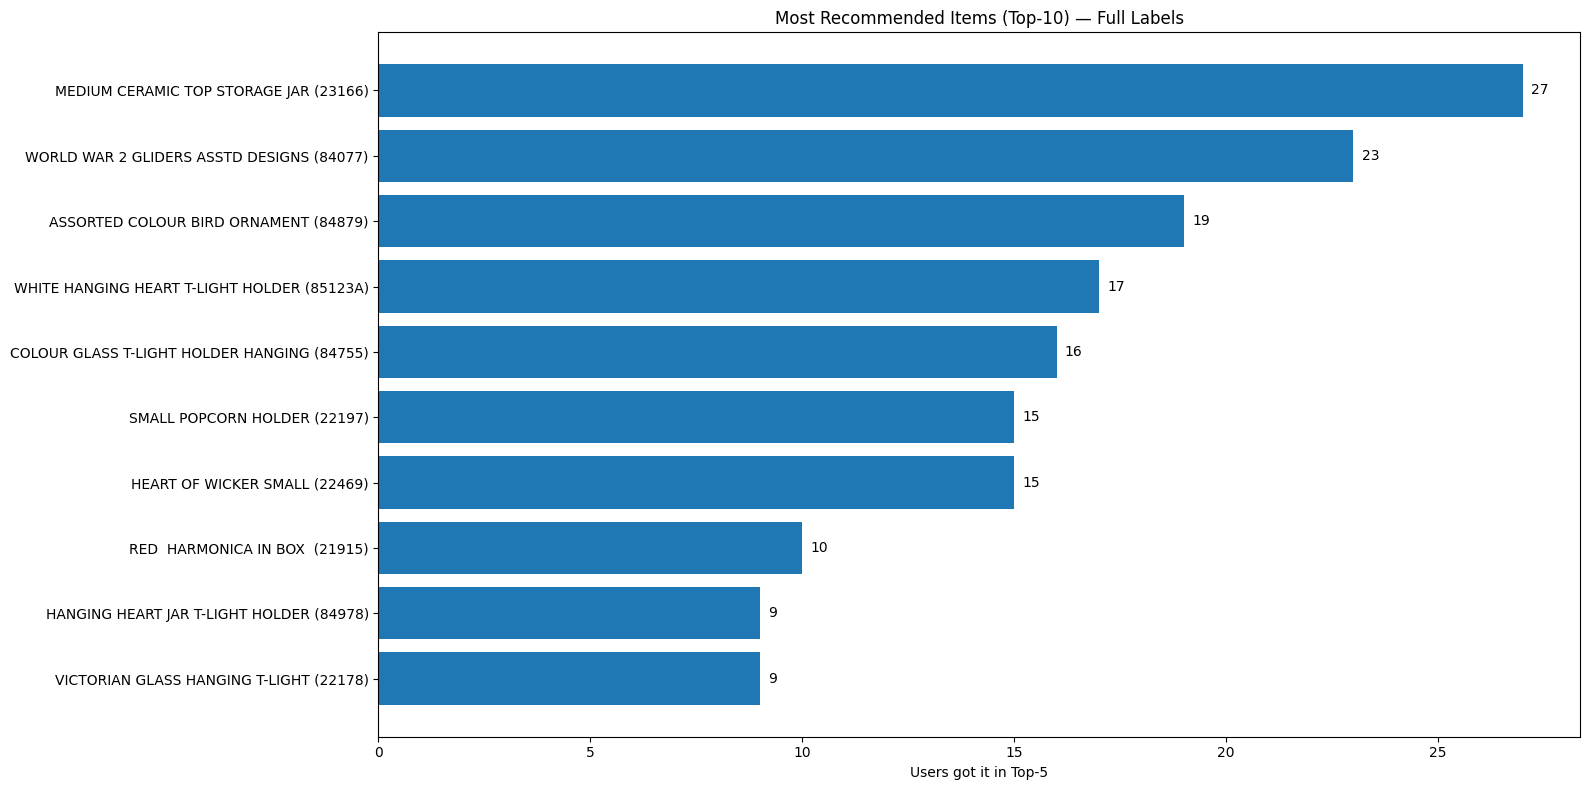

Saved: /work/output/plot_als_most_recommended_full.png


In [19]:
OUTDIR = globals().get("OUTDIR", "/work/output")
ALS_CSV = f"{OUTDIR}/als_recommendations_top5_sample100.csv"

'''
Prepare als_out:
Try loading previously exported recommendations; if missing, train a small ALS to reproduce.

'''
if "als_out" not in globals():
    if os.path.exists(ALS_CSV):
        
        als_out = pd.read_csv(ALS_CSV) # a) Load from local CSV
        print(f"[info] loaded ALS recommendations from {ALS_CSV}, rows =", len(als_out))
    else:
        from pyspark.ml.feature import StringIndexer # b)Train a compact ALS model (implicit feedback)
        from pyspark.ml.recommendation import ALS

        # Load sales parquet if not already loaded
        if "sales" not in globals():
            sales = spark.read.parquet("hdfs://namenode:9000/datasets/retail_clean_parquet")

        # Build implicit feedback matrix by summing quantities
        user_item = (
            sales.groupBy("CustomerID","StockCode")
                 .agg(F.sum("Quantity").alias("qty"))
                 .filter(F.col("qty") > 0)
        )

         # Index string IDs to consecutive ints (required by ALS)
        cust_indexer = StringIndexer(inputCol="CustomerID", outputCol="userId", handleInvalid="skip")
        item_indexer = StringIndexer(inputCol="StockCode",  outputCol="itemId", handleInvalid="skip")
        cust_model = cust_indexer.fit(user_item)
        item_model = item_indexer.fit(user_item)
        ui_idx = item_model.transform(cust_model.transform(user_item)).select("userId","itemId","qty")

        # Train ALS (implicitPrefs=True; small params for stability)
        als = ALS(userCol="userId", itemCol="itemId", ratingCol="qty",
                  implicitPrefs=True, nonnegative=True, coldStartStrategy="drop",
                  rank=10, maxIter=5, regParam=0.05, alpha=1.0, seed=42)
        als_model = als.fit(ui_idx)

        # Recommend Top-5 for first 100 users and convert to pandas
        topN_small = als_model.recommendForAllUsers(5).limit(100).toPandas()

        # Decode back to original CustomerID / StockCode
        cust_labels = cust_model.labels
        item_labels = item_model.labels

        def decode_recs(pdf):
            # Flatten nested recommendations to three columns
            rows = []
            for _, r in pdf.iterrows():
                uid = int(r["userId"])
                cust = cust_labels[uid] if uid < len(cust_labels) else str(uid)
                for rec in r["recommendations"]:
                    iid = int(rec["itemId"])
                    item = item_labels[iid] if iid < len(item_labels) else str(iid)
                    score = float(rec["rating"])
                    rows.append((cust, item, score))
            return pd.DataFrame(rows, columns=["CustomerID","StockCode","score"])

        als_out = decode_recs(topN_small)
        os.makedirs(OUTDIR, exist_ok=True)
        als_out.to_csv(ALS_CSV, index=False)
        print(f"[info] trained ALS and saved to {ALS_CSV}, rows =", len(als_out))

# Build mapping "Full Item Label = Description (StockCode)"
if "sales" not in globals():
    sales = spark.read.parquet("hdfs://namenode:9000/datasets/retail_clean_parquet")

TOPN = 10          # Top-N items to show
WRAP = 55          # wrap width for long labels
FIG_W, FIG_H = 16, 8

# Only collect descriptions for needed StockCodes
want_codes = list(set(als_out["StockCode"]))
look = (sales.select("StockCode","Description")
             .filter(F.col("StockCode").isin(want_codes))
             .dropna(subset=["Description"])
             .dropDuplicates(["StockCode"])
             .toPandas())
code2desc = dict(zip(look["StockCode"], look["Description"]))

# Compose full label "Description (Code)" and apply word-wrap for readability
als_disp = als_out.copy()
als_disp["ItemLabelFull"] = als_disp["StockCode"].astype(str).map(
    lambda c: f"{code2desc.get(c, '')} ({c})" if code2desc.get(c) else str(c)
)
als_disp["ItemLabelWrapped"] = als_disp["ItemLabelFull"].apply(lambda s: fill(s, width=WRAP))

# Count how many users received each item in Top-5 and plot
popular = (als_disp.groupby("ItemLabelWrapped")["CustomerID"]
                    .count()
                    .sort_values(ascending=False)
                    .head(TOPN))

fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))
bars = ax.barh(popular.index, popular.values)
ax.invert_yaxis() # Largest on top
ax.set_xlabel("Users got it in Top-5")
ax.set_title(f"Most Recommended Items (Top-{TOPN}) — Full Labels")

# Annotate counts at the end of each bar
for rect, val in zip(bars, popular.values):
    ax.annotate(str(int(val)),
                xy=(val, rect.get_y() + rect.get_height()/2),
                xytext=(6, 0), textcoords="offset points", va="center")


plt.subplots_adjust(left=0.42)
plt.tight_layout()

out_png = f"{OUTDIR}/plot_als_most_recommended_full.png"
os.makedirs(OUTDIR, exist_ok=True)
plt.savefig(out_png, dpi=140)
plt.show()
print("Saved:", out_png)

25/10/13 15:23:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---+-----+----------+-------------+
|ABC|items|revenue   |revenue_share|
+---+-----+----------+-------------+
|A  |837  |8532915.51|0.8          |
|B  |1023 |1599899.44|0.15         |
|C  |2301 |533869.59 |0.05         |
+---+-----+----------+-------------+

Saved CSV: /work/output/product_abc_top100.csv


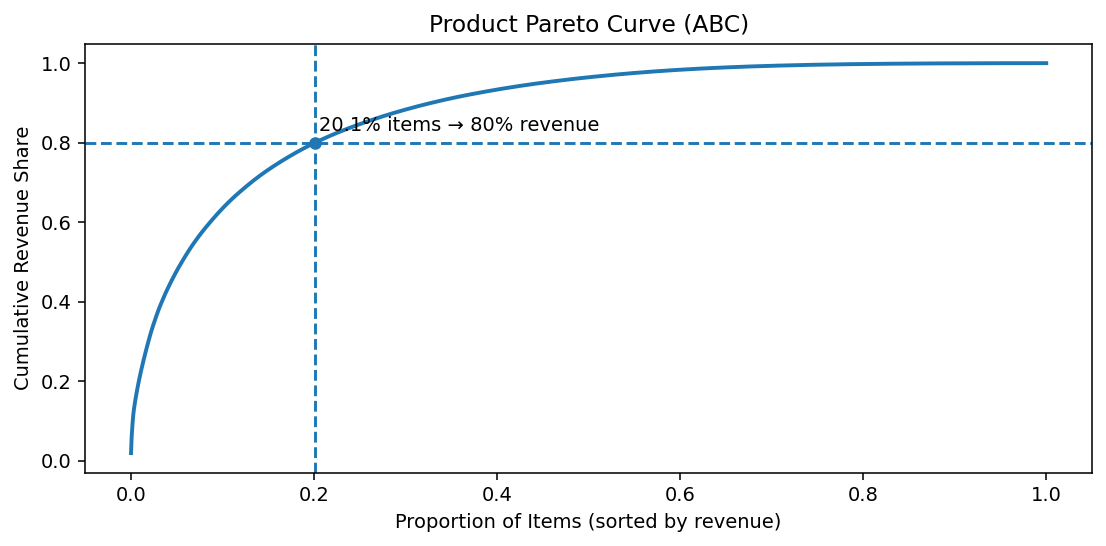

Saved plot: /work/output/plot_product_pareto.png


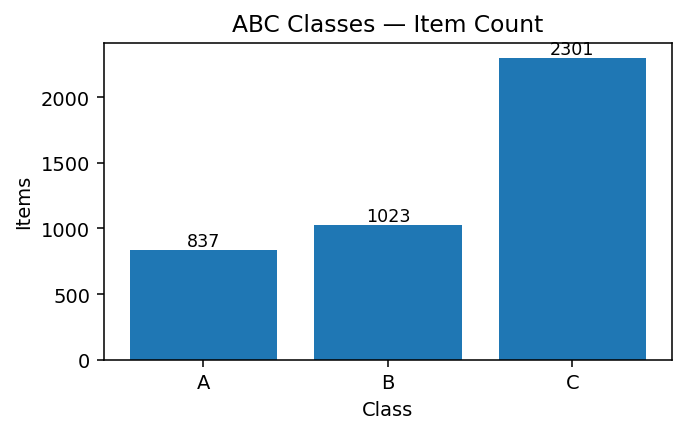

Saved plot: /work/output/plot_product_abc_counts.png


In [20]:
OUTDIR = globals().get("OUTDIR", "/work/output")
os.makedirs(OUTDIR, exist_ok=True)

# Choose source df and add Amount column (Quantity * UnitPrice); filter bad rows
df_src = sales if "sales" in globals() else sales_with_rev
df_src = df_src.withColumn("Amount", (F.col("Quantity")*F.col("UnitPrice")).cast("double")) \
               .filter((F.col("Quantity") > 0) & (F.col("UnitPrice") > 0))

# Aggregate to product level (StockCode + Description), sum revenue
prod_rev = (df_src.groupBy("StockCode","Description")
                 .agg(F.round(F.sum("Amount"), 2).alias("Revenue")))

# Total revenue & sort by revenue; compute cumulative share for ABC bucketing
tot_rev = prod_rev.agg(F.sum("Revenue")).collect()[0][0]
w = Window.orderBy(F.desc("Revenue")).rowsBetween(Window.unboundedPreceding, Window.currentRow)

prod_rank = (prod_rev
    .orderBy(F.desc("Revenue"))
    .withColumn("rank", F.row_number().over(Window.orderBy(F.desc("Revenue")))) #  rank
    .withColumn("cum_rev", F.sum("Revenue").over(w)) # cumulative revenue
    .withColumn("cum_share", F.col("cum_rev") / F.lit(tot_rev)) # cumulative share

    # ABC classes with typical cutoffs (A: ≤80%, B: ≤95%, C: rest)
    .withColumn("ABC", 
        F.when(F.col("cum_share") <= 0.80, "A")
         .when(F.col("cum_share") <= 0.95, "B")
         .otherwise("C"))
    .cache())

# ABC summary: item count, revenue, revenue share per class
abc_summary = (prod_rank.groupBy("ABC")
               .agg(F.count("*").alias("items"),
                    F.round(F.sum("Revenue"),2).alias("revenue"),
                    F.round(F.sum("Revenue")/F.lit(tot_rev),3).alias("revenue_share"))
               .orderBy("ABC"))
abc_summary.show(truncate=False)

# Save top-100 product details for the report/appendix
prod_rank.limit(100).toPandas().to_csv(f"{OUTDIR}/product_abc_top100.csv", index=False)
print("Saved CSV:", f"{OUTDIR}/product_abc_top100.csv")

# Pareto (Lorenz-like) curve: what % of items contributes 80% of revenue
p_pd = prod_rank.select("rank","cum_share").orderBy("rank").toPandas()
if len(p_pd) == 0:
    raise ValueError("No product data available for plotting.")

total_n = int(prod_rank.count())
# Proportion of items to reach 80% revenue
rank80 = prod_rank.filter(F.col("cum_share") <= 0.80).agg(F.max("rank")).collect()[0][0]
x80 = rank80 / total_n

plt.figure(figsize=(8,4), dpi=140)
plt.plot(p_pd["rank"]/total_n, p_pd["cum_share"], linewidth=2) #cumulative curve
plt.axhline(0.8, linestyle="--") # 80% line
plt.axvline(x80, linestyle="--") # required item share
plt.scatter([x80], [0.8], s=30)

# X% items → 80% revenue
plt.text(x80*1.02, 0.82, f"{x80*100:.1f}% items → 80% revenue", va="bottom")
plt.xlabel("Proportion of Items (sorted by revenue)")
plt.ylabel("Cumulative Revenue Share")
plt.title("Product Pareto Curve (ABC)")
plt.tight_layout()
png_path = f"{OUTDIR}/plot_product_pareto.png"
plt.savefig(png_path)
plt.show()
print("Saved plot:", png_path)

# ABC bar chart: item count per class
abc_pd = abc_summary.toPandas().sort_values("ABC")
plt.figure(figsize=(5,3.2), dpi=140)
bars = plt.bar(abc_pd["ABC"], abc_pd["items"])
for b, n in zip(bars, abc_pd["items"]):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), str(int(n)), ha="center", va="bottom", fontsize=9)
plt.title("ABC Classes — Item Count")
plt.xlabel("Class")
plt.ylabel("Items")
plt.tight_layout()
png2 = f"{OUTDIR}/plot_product_abc_counts.png"
plt.savefig(png2)
plt.show()
print("Saved plot:", png2)


In [21]:
SEED = 42 # Random seed for reproducibility

# Create a fallback InvoiceTs if missing (try multiple formats)
ts_col = "InvoiceTs" if "InvoiceTs" in sales.columns else ("InvoiceTS" if "InvoiceTS" in sales.columns else None)
if ts_col is None:
    sales = sales.withColumn("InvoiceTs",
             F.coalesce(F.to_timestamp("InvoiceDate","yyyy/M/d H:mm"),
                        F.to_timestamp("InvoiceDate","MM/dd/yyyy HH:mm"),
                        F.to_timestamp("InvoiceDate")) )
    ts_col = "InvoiceTs"

# Add Amount column and get reference timestamp (most recent transaction)
sales = sales.withColumn("Amount", (F.col("Quantity")*F.col("UnitPrice")).cast("double"))
ref_ts = sales.agg(F.max(F.col(ts_col))).first()[0]

# Compute R/F/M per customer; keep customers with F>0
rfm = (sales.groupBy("CustomerID")
             .agg(F.datediff(F.lit(ref_ts), F.max(F.col(ts_col))).alias("R"), # Recency (days)
                  F.countDistinct("InvoiceNo").alias("F"), # Frequency (orders)
                  F.sum("Amount").cast("double").alias("M"))  # Monetary (spend)
             .filter("F > 0"))

# Assemble features and standardize (mean=0, std=1); cache result
va  = VectorAssembler(inputCols=["R","F","M"], outputCol="feat")
sc  = StandardScaler(inputCol="feat", outputCol="scaled", withStd=True, withMean=True).fit(va.transform(rfm))
rfm_std = sc.transform(va.transform(rfm)).cache()

# Train/test split (80/20)
train, test = rfm_std.randomSplit([0.8, 0.2], seed=SEED)

# Train KMeans (k=4) and get predictions for train/test
km = KMeans(k=4, seed=SEED, featuresCol="scaled", predictionCol="pred")
km_model = km.fit(train)

# Evaluate clustering with Silhouette score (higher is better) on train/test
pred_tr, pred_te = km_model.transform(train), km_model.transform(test)
ev = ClusteringEvaluator(featuresCol="scaled", predictionCol="pred",
                         metricName="silhouette", distanceMeasure="squaredEuclidean")

print({"silhouette_train": round(ev.evaluate(pred_tr),4),
       "silhouette_test":  round(ev.evaluate(pred_te),4)})


{'silhouette_train': 0.8505, 'silhouette_test': 0.8564}


In [22]:
try:
    sales
except NameError:
    # If `sales` is missing, load cleaned Parquet from HDFS and basic filtering
    sales = spark.read.parquet("hdfs://namenode:9000/datasets/retail_clean_parquet")
    sales = sales.filter((F.col("Quantity") > 0) & (F.col("UnitPrice") > 0))


try:
    OUTDIR
except NameError:
    OUTDIR = "/work/output"

SEED, K, TOPK_RECS = 42, 10, 100

# Build implicit feedback by summing quantities per (user,item)
ui_raw = (sales
          .select("CustomerID","StockCode","Quantity")
          .filter(F.col("CustomerID").isNotNull() & F.col("StockCode").isNotNull())
          .groupBy("CustomerID","StockCode").agg(F.sum("Quantity").alias("qty"))
          .filter("qty > 0"))

# StringIndex to integer IDs for ALS, then explicit cast to int
u_idx = StringIndexer(inputCol="CustomerID", outputCol="userId", handleInvalid="skip").fit(ui_raw)
i_idx = StringIndexer(inputCol="StockCode",  outputCol="itemId", handleInvalid="skip").fit(ui_raw)
ui = (i_idx.transform(u_idx.transform(ui_raw))
        .select(F.col("userId").cast("int").alias("userId"),
                F.col("itemId").cast("int").alias("itemId"),
                "qty"))

# User-wise 80/20 split; keep only users that have test interactions
spl   = ui.withColumn("is_train", (F.rand(SEED) <= 0.8))
testU = spl.filter(~F.col("is_train")).select("userId").distinct()
train = spl.filter("is_train").join(testU, "userId")
test  = (spl.filter(~F.col("is_train")).join(testU, "userId")
            .select("userId","itemId").distinct())

# Train ALS for implicit feedback; nonnegative; drop cold-start predictions
als = ALS(userCol="userId", itemCol="itemId", ratingCol="qty",
          implicitPrefs=True, nonnegative=True,
          coldStartStrategy="drop", rank=10, maxIter=5, regParam=0.05, alpha=1.0,
          seed=SEED)
model = als.fit(train)

# Generate candidate predictions, remove seen (train) items, keep Top-K per user
recs = (model.recommendForAllUsers(TOPK_RECS)
        .select("userId", F.explode("recommendations").alias("rec"))
        .select("userId", F.col("rec.itemId").alias("itemId"),
                          F.col("rec.rating").alias("rating")))
seen = train.select("userId","itemId").distinct()
cand = recs.join(seen, ["userId","itemId"], "left_anti")

als_pred_topk = (cand.groupBy("userId")
    .agg(F.sort_array(F.collect_list(F.struct("rating","itemId")), asc=False).alias("arr"))
    .select("userId", F.expr(f"transform(slice(arr,1,{K}), x -> x.itemId)").alias("pred")))

als_test = test  # Ground-truth interactions for evaluation

'''
===== Simple evaluation: Precision/Recall/HitRate/NDCG/MRR at K =====

'''
# Explode Top-K predictions with rank
pred_exp = (als_pred_topk
    .select("userId", F.posexplode("pred").alias("pos","itemId"))
    .withColumn("rank", F.col("pos")+1)
    .filter(F.col("rank") <= K)
    .drop("pos"))

# 2) Hits = predicted ∩ actual
hits = pred_exp.join(als_test, ["userId","itemId"])

# Per-user aggregation: #hits, first hit rank, #pred@K, #actual
per_user_hits = hits.groupBy("userId").agg(
    F.count("*").alias("hits"),
    F.min("rank").alias("first_hit_rank")
)
pred_counts   = pred_exp.groupBy("userId").agg(F.count("*").alias("pred_k"))
actual_counts = als_test.groupBy("userId").agg(F.countDistinct("itemId").alias("actual"))

joined = (pred_counts
          .join(actual_counts, "userId", "left")
          .join(per_user_hits, "userId", "left")
          .fillna({"hits":0}))

# Precision@K, Recall@K, HitRate@K (hit if at least one match)
precision_k = joined.select(F.avg(F.col("hits")/F.col("pred_k")).alias(f"Precision@{K}"))
recall_k    = joined.select(F.avg(F.col("hits")/F.least(F.col("actual"), F.lit(K))).alias(f"Recall@{K}"))
hitrate_k   = joined.select(F.avg(F.when(F.col("hits")>0, 1).otherwise(0)).alias(f"HitRate@{K}"))

# NDCG@K: compute DCG, then normalize by ideal DCG (IDCG)
dcg = hits.groupBy("userId").agg(
    F.sum(1.0 / (F.log(F.col("rank")+1) / F.log(F.lit(2.0)))).alias("dcg")
)
idcg = (actual_counts
    .select("userId", F.least(F.col("actual"), F.lit(K)).alias("L"))
    .withColumn("seq", F.expr("sequence(1, L)"))
    .withColumn("idcg", F.expr("aggregate(seq, double(0), (acc,p) -> acc + (1.0/(log(p+1)/log(2.0))))"))
    .select("userId","idcg"))
ndcg = (dcg.join(idcg, "userId", "right")
    .select(F.avg(F.when(F.col("idcg")>0, F.col("dcg")/F.col("idcg")).otherwise(0)).alias(f"NDCG@{K}")))

# MRR@K: mean reciprocal rank of the first hit
mrr = joined.select(
    F.avg(F.when(F.col("first_hit_rank").isNotNull(), 1.0/F.col("first_hit_rank")).otherwise(0.0)).alias(f"MRR@{K}")
)

# Aggregate and display
metrics_simple = precision_k.crossJoin(recall_k).crossJoin(hitrate_k).crossJoin(ndcg).crossJoin(mrr)
metrics_simple.show(truncate=False)

# Save metrics to CSV
metrics_simple.toPandas().to_csv(f"{OUTDIR}/als_eval_metrics.csv", index=False)
print("Saved:", f"{OUTDIR}/als_eval_metrics.csv")

+-------------------+-------------------+-------------------+-------------------+-------------------+
|Precision@10       |Recall@10          |HitRate@10         |NDCG@10            |MRR@10             |
+-------------------+-------------------+-------------------+-------------------+-------------------+
|0.03145983586172592|0.04689763661412506|0.24297438448147227|0.17002594652334282|0.09041954342874513|
+-------------------+-------------------+-------------------+-------------------+-------------------+



Saved: /work/output/als_eval_metrics.csv
